In [1443]:
# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json


from utils.save import *



In [1444]:
# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'mean_last_100_loss' # ou 'mean_last_100_loss'

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

In [1445]:
# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

all_dfs = []

try:
    df_classic = pd.read_csv(SUMMARY_CLASSIC_PATH)
    all_dfs.append(df_classic)
    print(f"Carregado {len(df_classic)} runs de '{SUMMARY_CLASSIC_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CLASSIC_PATH}' não encontrado. Pulando.")

try:
    df_hybrid = pd.read_csv(SUMMARY_HYBRID_PATH)
    all_dfs.append(df_hybrid)
    print(f"Carregado {len(df_hybrid)} runs de '{SUMMARY_HYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_HYBRID_PATH}' não encontrado. Pulando.")

try:
    df_quantum = pd.read_csv(SUMMARY_QUANTUM_PATH)
    all_dfs.append(df_quantum)
    print(f"Carregado {len(df_quantum)} runs de '{SUMMARY_QUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_QUANTUM_PATH}' não encontrado. Pulando.")

try:
    df_quantum = pd.read_csv(SUMMARY_CQUANTUM_PATH)
    all_dfs.append(df_quantum)
    print(f"Carregado {len(df_quantum)} runs de '{SUMMARY_CQUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CQUANTUM_PATH}' não encontrado. Pulando.")
try:
    df_chybrid = pd.read_csv(SUMMARY_CHYBRID_PATH)
    all_dfs.append(df_chybrid)
    print(f"Carregado {len(df_chybrid)} runs de '{SUMMARY_CHYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CHYBRID_PATH}' não encontrado. Pulando.")



if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    exit()

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

Carregado 210 runs de 'experimentos_pinn/sumario_classico.csv'
Carregado 192 runs de 'experimentos_pinn/sumario_hibrido.csv'
Carregado 346 runs de 'experimentos_pinn/sumario_quantico.csv'
Carregado 384 runs de 'experimentos_pinn/sumario_cquantico.csv'
Carregado 359 runs de 'experimentos_pinn/sumario_chibrido.csv'


In [1446]:
#df_all[df_all["model_type"] == "CQNN"]
#df_cqnn

# 1) CQNN effect

## 1.1) Same #'s output - Strong

In [1447]:
# ==========================================
# 1. Filtragem dos dados
# ==========================================
entangler = 'strong'
valid_seeds = [1924, 1925, 1926, 1973, 2025, 2024, 2012, 1958, 1962, 1997]

df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_qubits"] == 7) &
    (df_all["seed"].isin(valid_seeds))  # filtragem pelas seeds
]

df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_vertex"] == 7) &
    (df_all["seed"].isin(valid_seeds))  # filtragem pelas seeds
]

/tmp/ipykernel_5677/1410907200.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_5677/1410907200.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_5677/1410907200.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


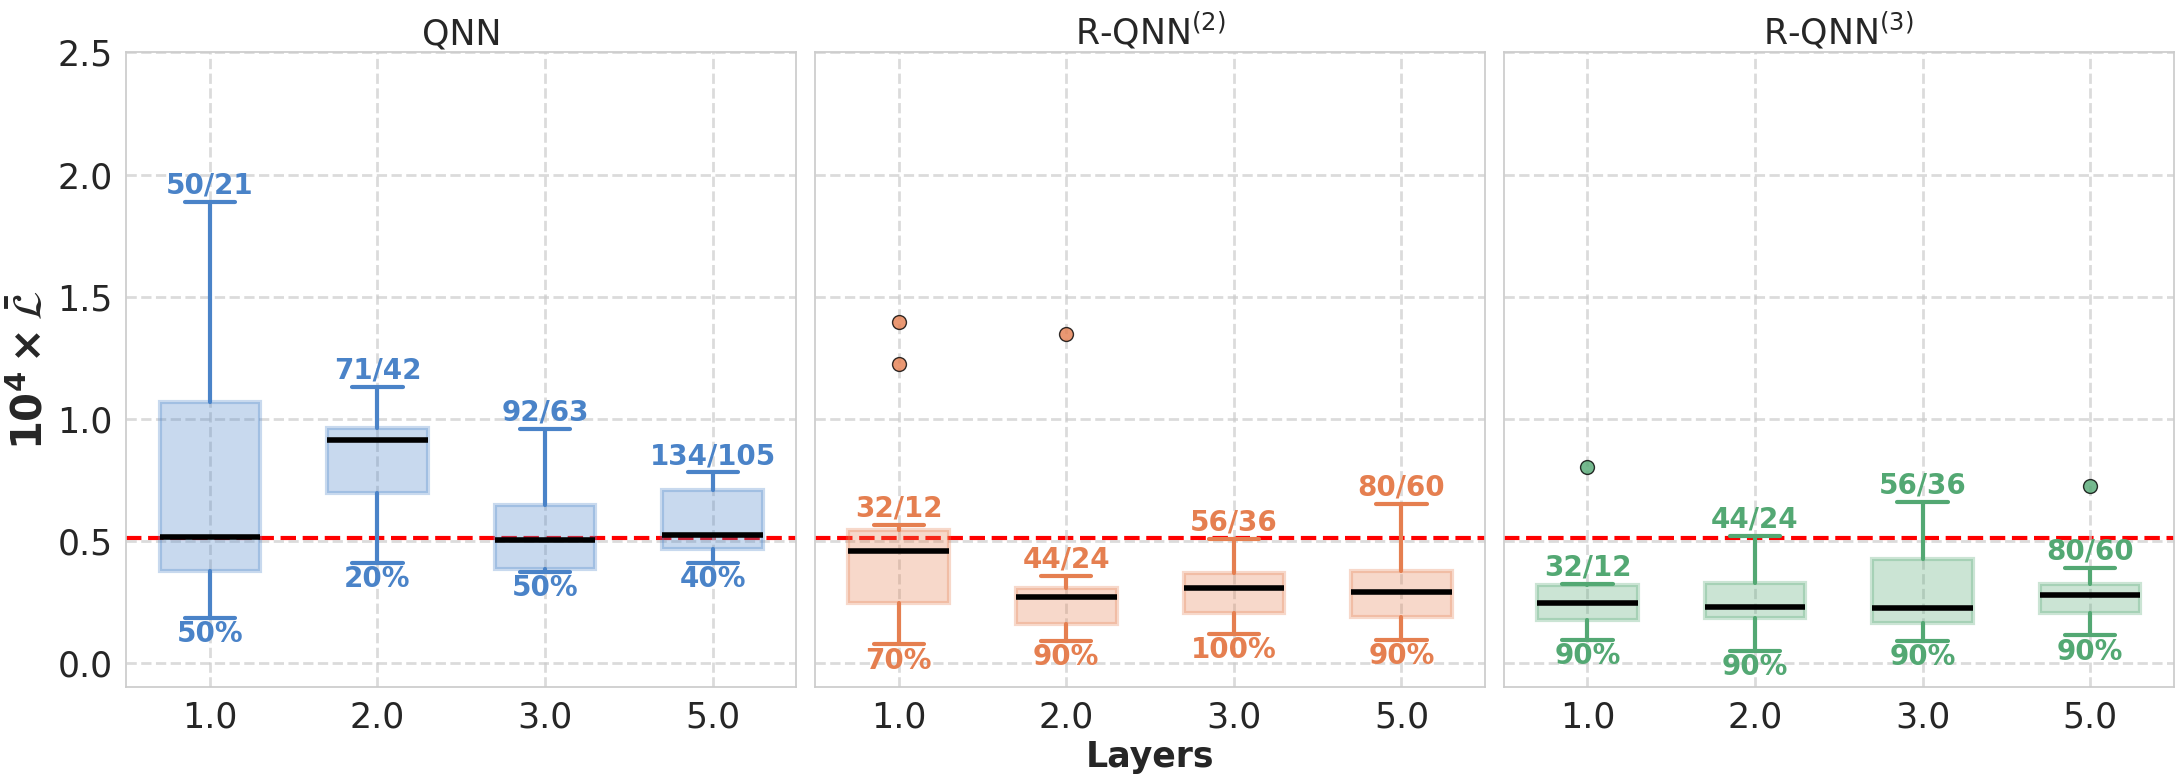

In [1448]:
# ==========================================
# 2. Fator de escala
# ==========================================
factor = 10**4

# ==========================================
# 3. Agrupamento — QNN
# ==========================================
groups_qnn = df_qnn.groupby("n_layers")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_qnn = groups_qnn.tolist()
labels_qnn = [f"{nl}" for nl in groups_qnn.index]

params_qnn = df_qnn.groupby("n_layers")["num_params"].first().to_dict()
nqubits_qnn = df_qnn.groupby("n_layers")["n_qubits"].first().to_dict()

# ==========================================
# 4. Agrupamento — CQNN por K=2 e K=3
# ==========================================
groups_cqnn_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
groups_cqnn_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)

data_k2 = groups_cqnn_k2.tolist()
data_k3 = groups_cqnn_k3.tolist()

labels_k2 = [f"{nl}" for nl in groups_cqnn_k2.index]
labels_k3 = [f"{nl}" for nl in groups_cqnn_k3.index]

params_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["num_params"].first().to_dict()
params_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["num_params"].first().to_dict()

nqubits_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["n_qubits"].first().to_dict()
nqubits_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["n_qubits"].first().to_dict()

# ==========================================
# 4.1. Funções de parâmetros quânticos
# ==========================================
def n_quantum_params(n_qubits, n_layers, entangler_type: str):
    et = entangler_type.lower()
    if et.startswith("basic"):
        return n_qubits * n_layers
    elif et.startswith("strong"):
        return 3 * n_qubits * n_layers
    else:
        return np.nan

def build_qparam_dict(nqubits_dict, entangler_type):
    return {L: n_quantum_params(nq, L, entangler_type) for L, nq in nqubits_dict.items()}

qparams_qnn = build_qparam_dict(nqubits_qnn, entangler)
qparams_k2  = build_qparam_dict(nqubits_k2,  entangler)
qparams_k3  = build_qparam_dict(nqubits_k3,  entangler)

# ==========================================
# Taxa de convergência
# ==========================================
threshold = (1 / 140**2) * factor

def compute_conv(groups, thr):
    return {L: 100 * np.mean(np.asarray(vals) < thr) for L, vals in groups.items()}

conv_qnn = compute_conv(groups_qnn, threshold)
conv_k2  = compute_conv(groups_cqnn_k2, threshold)
conv_k3  = compute_conv(groups_cqnn_k3, threshold)

# ==========================================
# Função de plot ajustada
# ==========================================
def plot_panel(
    ax, data, labels, params_total, params_quantum, conv,
    groups_index, title, color, show_ylabel=False, show_xlabel=False
):
    bp = ax.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        widths=0.6,
        medianprops=dict(color="black", linewidth=4),
        boxprops=dict(linewidth=3, edgecolor=color),
        whiskerprops=dict(linewidth=3, color=color),
        capprops=dict(linewidth=3, color=color),
        flierprops=dict(marker="o", markersize=10, markerfacecolor=color, alpha=0.8),
    )

    for box in bp["boxes"]:
        box.set_facecolor(color)
        box.set_alpha(0.30)

    # título sem bold
    ax.set_title(title, fontsize=25)

    # grid forte
    ax.grid(True, alpha=0.7, linestyle="--", linewidth=2.0, zorder=10)

    # linha vermelha por trás
    ax.axhline(y=threshold, color="red", linestyle="--", linewidth=3, zorder=-5)

    # ▸ valores mais próximos dos quartis
    ymin, ymax = ax.get_ylim()
    delta = (ymax - ymin) * 0.005   # menor que antes

    for i, L in enumerate(groups_index):
        x = i + 1

        w_low  = bp["whiskers"][2*i]
        w_high = bp["whiskers"][2*i + 1]

        y_low  = min(w_low.get_ydata())
        y_high = max(w_high.get_ydata())

        # parâmetros total/quântico — 20 pt, bold
        ax.text(
            x,
            y_high + delta,
            f"{params_total[L]}/{int(params_quantum[L])}",
            ha="center",
            va="bottom",
            fontsize=20,
            fontweight="bold",
            color=color
        )

        # convergência — 20 pt, bold
        ax.text(
            x,
            y_low - delta,
            f"{conv[L]:.0f}%",
            ha="center",
            va="top",
            fontsize=20,
            fontweight="bold",
            color=color
        )

    if show_ylabel:
        ax.set_ylabel("$\\mathbf{10^{4} \\times \\bar{\\mathcal{L}}}$", fontsize=30, fontweight="bold")

    if show_xlabel:
        ax.set_xlabel("Layers", fontsize=25, fontweight="bold")

    # ticks grandes e bold
    ax.tick_params(axis="x", labelsize=25, width=2)
    ax.tick_params(axis="y", labelsize=25, width=2)

# ==========================================
# 5. Plot geral
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)

# cores da sua imagem
color_qnn = "#4A83C8"   # azul
color_k2  = "#E57F50"   # laranja
color_k3  = "#53A873"   # verde

plot_panel(axes[0], data_qnn, labels_qnn, params_qnn, qparams_qnn,
           conv_qnn, groups_qnn.index, "QNN", color_qnn, show_ylabel=True)

plot_panel(axes[1], data_k2, labels_k2, params_k2, qparams_k2,
           conv_k2, groups_cqnn_k2.index, "R-QNN$^{(2)}$", color_k2, show_xlabel=True)

plot_panel(axes[2], data_k3, labels_k3, params_k3, qparams_k3,
           conv_k3, groups_cqnn_k3.index, "R-QNN$^{(3)}$", color_k3)

# ticks Y: 0 → 2.5
yticks = np.arange(0, 2.51, 0.5)
axes[0].set_ylim(-.1, 2.5)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{y:.1f}" for y in yticks], fontsize= 25)
for ax in axes[1:]:
    ax.tick_params(axis="y", labelsize=25)

plt.tight_layout()

plt.savefig(f"boxplot_qnn_cqnn_layers_{entangler}.png", dpi=300)
plt.show()


/tmp/ipykernel_5677/2611442570.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_qnn = ax.boxplot(data_qnn, labels=labels_qnn)
/tmp/ipykernel_5677/2611442570.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_k2 = ax.boxplot(data_k2, labels=labels_k2)
/tmp/ipykernel_5677/2611442570.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_k3 = ax.boxplot(data_k3, labels=labels_k3)


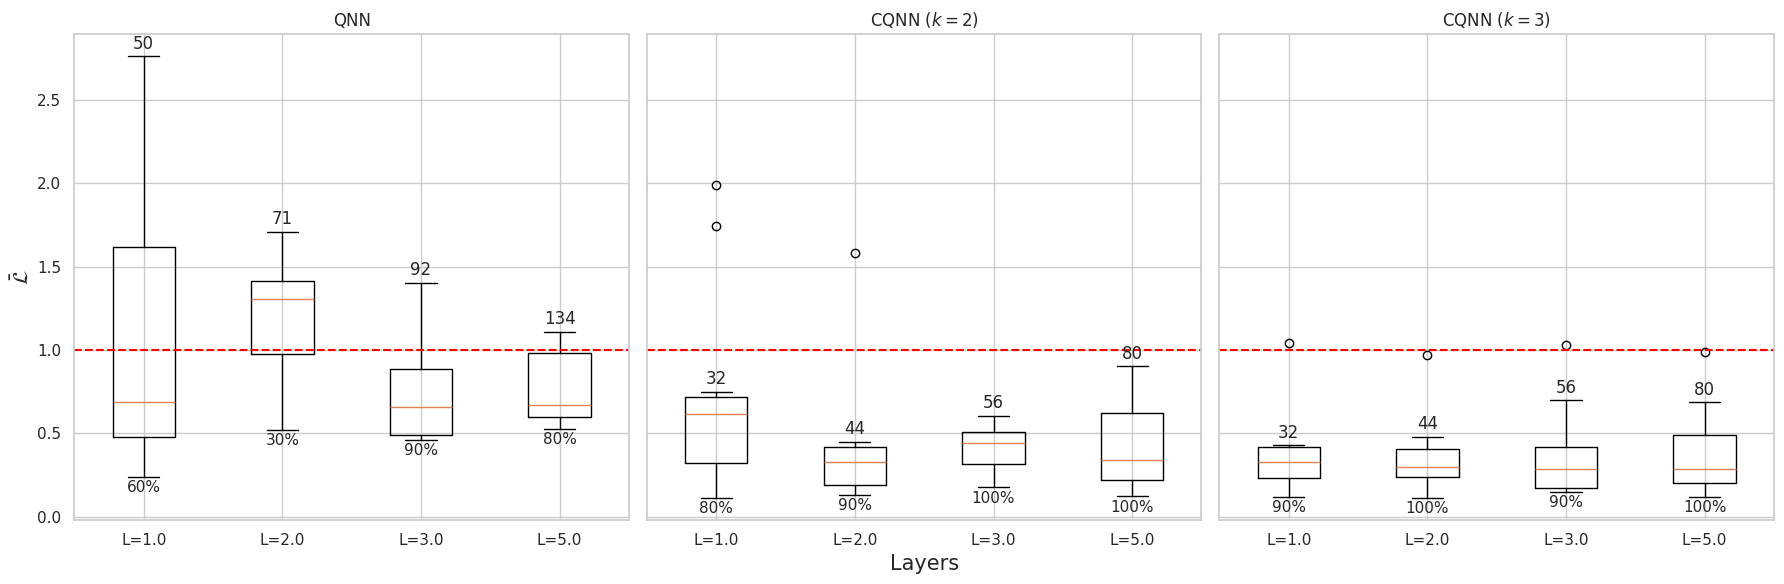

In [1449]:
# ==========================================
# 2. Métrica a ser usada
# ==========================================
test = "mse_teste_desnormalizado"

# ==========================================
# 3. Agrupamento — QNN
# ==========================================
groups_qnn = df_qnn.groupby("n_layers")[test].apply(lambda x: x.tolist())
data_qnn = groups_qnn.tolist()
labels_qnn = [f"L={nl}" for nl in groups_qnn.index]
params_qnn = df_qnn.groupby("n_layers")["num_params"].first().to_dict()

# ==========================================
# 4. Agrupamento — CQNN por K=2 e K=3
# ==========================================
groups_cqnn_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")[test].apply(lambda x: x.tolist())
groups_cqnn_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")[test].apply(lambda x: x.tolist())

data_k2 = groups_cqnn_k2.tolist()
data_k3 = groups_cqnn_k3.tolist()

labels_k2 = [f"L={nl}" for nl in groups_cqnn_k2.index]
labels_k3 = [f"L={nl}" for nl in groups_cqnn_k3.index]

params_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["num_params"].first().to_dict()
params_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["num_params"].first().to_dict()

# --------- Taxa de convergência ----------
import numpy as np

def compute_conv(groups, thr):
    conv = {}
    for L, vals in groups.items():
        arr = np.asarray(vals)
        conv[L] = 100 * np.mean(arr < thr)
    return conv

threshold = 1
conv_qnn = compute_conv(groups_qnn, threshold)
conv_k2  = compute_conv(groups_cqnn_k2, threshold)
conv_k3  = compute_conv(groups_cqnn_k3, threshold)

# ==========================================
# 5. Plotagem lado a lado (3 colunas)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# ---- CONFIGURAÇÃO ----
delta = 0.02   # <<< espaçamento pedido

# ==========================================
#  QNN
# ==========================================
ax = axes[0]
bp_qnn = ax.boxplot(data_qnn, labels=labels_qnn)
ax.set_title("QNN")
ax.set_ylabel(r"$\bar{\mathcal{L}}$", fontsize=15)
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for i, L in enumerate(groups_qnn.index):
    x_pos = i + 1

    # whiskers
    w_low  = bp_qnn["whiskers"][2*i]
    w_high = bp_qnn["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(x_pos, y_high + delta, f"{params_qnn[L]}",
            ha="center", va="bottom", fontsize=12)

    ax.text(x_pos, y_low - delta, f"{conv_qnn[L]:.0f}%",
            ha="center", va="top", fontsize=11)

# ==========================================
#  CQNN k = 2
# ==========================================
ax = axes[1]
bp_k2 = ax.boxplot(data_k2, labels=labels_k2)
ax.set_title("CQNN ($k = 2$)")
ax.set_xlabel("Layers", fontsize=15)
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for i, L in enumerate(groups_cqnn_k2.index):
    x_pos = i + 1

    w_low  = bp_k2["whiskers"][2*i]
    w_high = bp_k2["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(x_pos, y_high + delta, f"{params_k2[L]}",
            ha="center", va="bottom", fontsize=12)

    ax.text(x_pos, y_low - delta, f"{conv_k2[L]:.0f}%",
            ha="center", va="top", fontsize=11)

# ==========================================
#  CQNN k = 3
# ==========================================
ax = axes[2]
bp_k3 = ax.boxplot(data_k3, labels=labels_k3)
ax.set_title("CQNN ($k = 3$)")
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for i, L in enumerate(groups_cqnn_k3.index):
    x_pos = i + 1

    w_low  = bp_k3["whiskers"][2*i]
    w_high = bp_k3["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(x_pos, y_high + delta, f"{params_k3[L]}",
            ha="center", va="bottom", fontsize=12)

    ax.text(x_pos, y_low - delta, f"{conv_k3[L]:.0f}%",
            ha="center", va="top", fontsize=11)

plt.tight_layout()
plt.show()


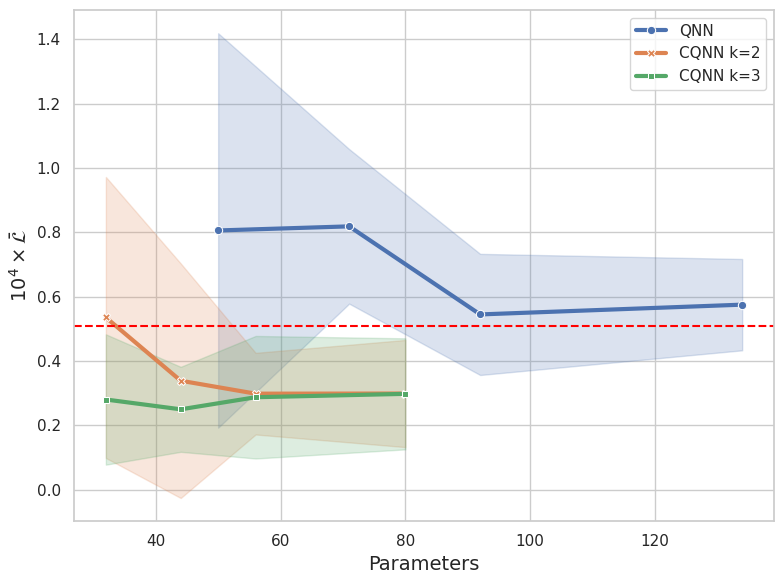

In [1450]:
import seaborn as sns

factor = 10**4

# ----- preparar dataframes com coluna de modelo -----
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_["mean_last_100_loss"] * factor

# junta tudo num único DF
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# ----- plot com seaborn: linha + incerteza -----
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",
    y="loss_scaled",
    hue="model",
    style="model",
    lw=3,
    markers=True,
    dashes=False,
    errorbar="sd",    # média ± desvio padrão
    ax=ax
)

threshold = (1 / 140**2) * factor
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Parameters", fontsize=14)
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=14)
ax.legend(title=None)
plt.tight_layout()
plt.show()

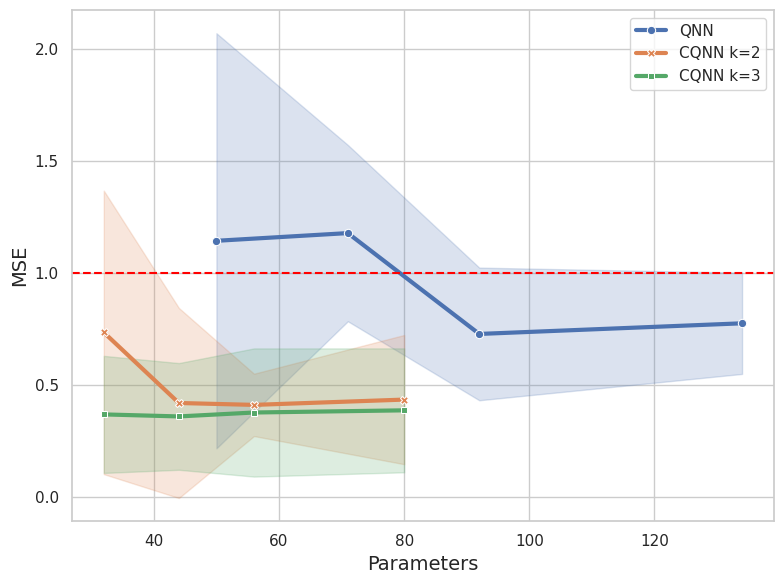

In [1451]:
# ----- preparar dataframes com coluna de modelo -----
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_[test]

# junta tudo num único DF
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# ----- plot com seaborn: linha + incerteza -----
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",
    y="loss_scaled",
    hue="model",
    style="model",
    lw=3,
    markers=True,
    dashes=False,
    errorbar="sd",    # média ± desvio padrão
    ax=ax
)

threshold = 1
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Parameters", fontsize=14)
ax.set_ylabel("MSE", fontsize=14)
ax.legend(title=None)
plt.tight_layout()
plt.show()

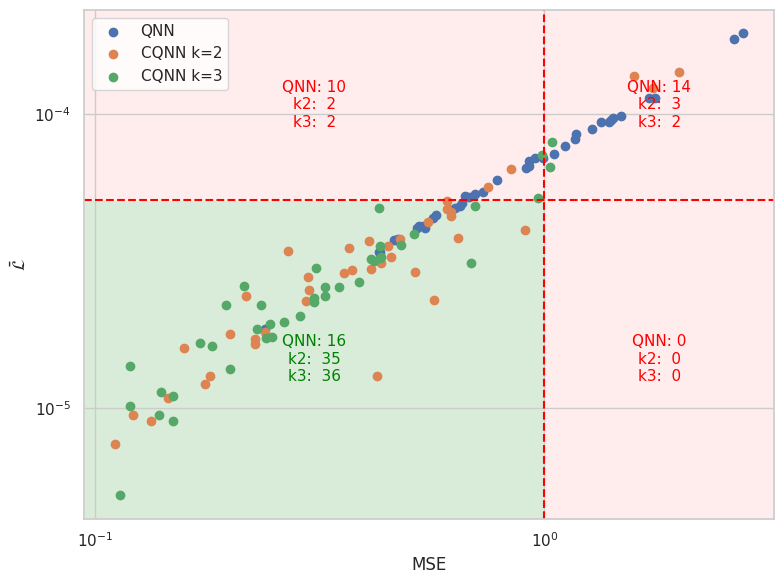

In [1452]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# -----------------------------
# suas variáveis e dados
# -----------------------------
x_qnn = df_qnn_plot['mse_teste_desnormalizado'].values
y_qnn = df_qnn_plot['mean_last_100_loss'].values

x_k2  = df_k2_plot['mse_teste_desnormalizado'].values
y_k2  = df_k2_plot['mean_last_100_loss'].values

x_k3  = df_k3_plot['mse_teste_desnormalizado'].values
y_k3  = df_k3_plot['mean_last_100_loss'].values

tx = 1        # threshold em x (MSE normalizado)
ty = 1 / 140**2             # threshold em y (loss)

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------
def quadrant_counts(x, y, tx, ty):
    x = np.asarray(x); y = np.asarray(y)
    return {
        "Q1": np.sum((x >= tx) & (y >= ty)),  # cima-direita
        "Q2": np.sum((x <  tx) & (y >= ty)),  # cima-esquerda
        "Q3": np.sum((x <  tx) & (y <  ty)),  # baixo-esquerda
        "Q4": np.sum((x >= tx) & (y <  ty)),  # baixo-direita
    }

cnt_qnn = quadrant_counts(x_qnn, y_qnn, tx, ty)
cnt_k2  = quadrant_counts(x_k2,  y_k2,  tx, ty)
cnt_k3  = quadrant_counts(x_k3,  y_k3,  tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x_qnn, y_qnn, label="QNN")
ax.scatter(x_k2,  y_k2,  label="CQNN k=2")
ax.scatter(x_k3,  y_k3,  label="CQNN k=3")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE")
ax.set_ylabel("$\\bar{\\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde
ax.text(
    xL, yB,
    f"QNN: {cnt_qnn['Q3']}\n"
    f"k2:  {cnt_k2['Q3']}\n"
    f"k3:  {cnt_k3['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"QNN: {cnt_qnn['Q2']}\n"
    f"k2:  {cnt_k2['Q2']}\n"
    f"k3:  {cnt_k3['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"QNN: {cnt_qnn['Q4']}\n"
    f"k2:  {cnt_k2['Q4']}\n"
    f"k3:  {cnt_k3['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"QNN: {cnt_qnn['Q1']}\n"
    f"k2:  {cnt_k2['Q1']}\n"
    f"k3:  {cnt_k3['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

ax.legend()
plt.tight_layout()
plt.show()



## 1.2) Same #'s qubits - Strong

In [1453]:
# =========================================================
# 0. Configuração
# =========================================================
n_layers_fixed = 3        # <-- escolha aqui o número de layers fixo
entangler = "strong"      # ou "basic"
factor = 10**4
threshold = (1 / 140**2) * factor

n_qubits_cqnn_fixed = 4  # <-- ajuste aqui

/tmp/ipykernel_5677/810016178.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_qnn, labels=labels_qnn)
/tmp/ipykernel_5677/810016178.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_k2, labels=labels_k2)
/tmp/ipykernel_5677/810016178.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_k3, labels=labels_k3)


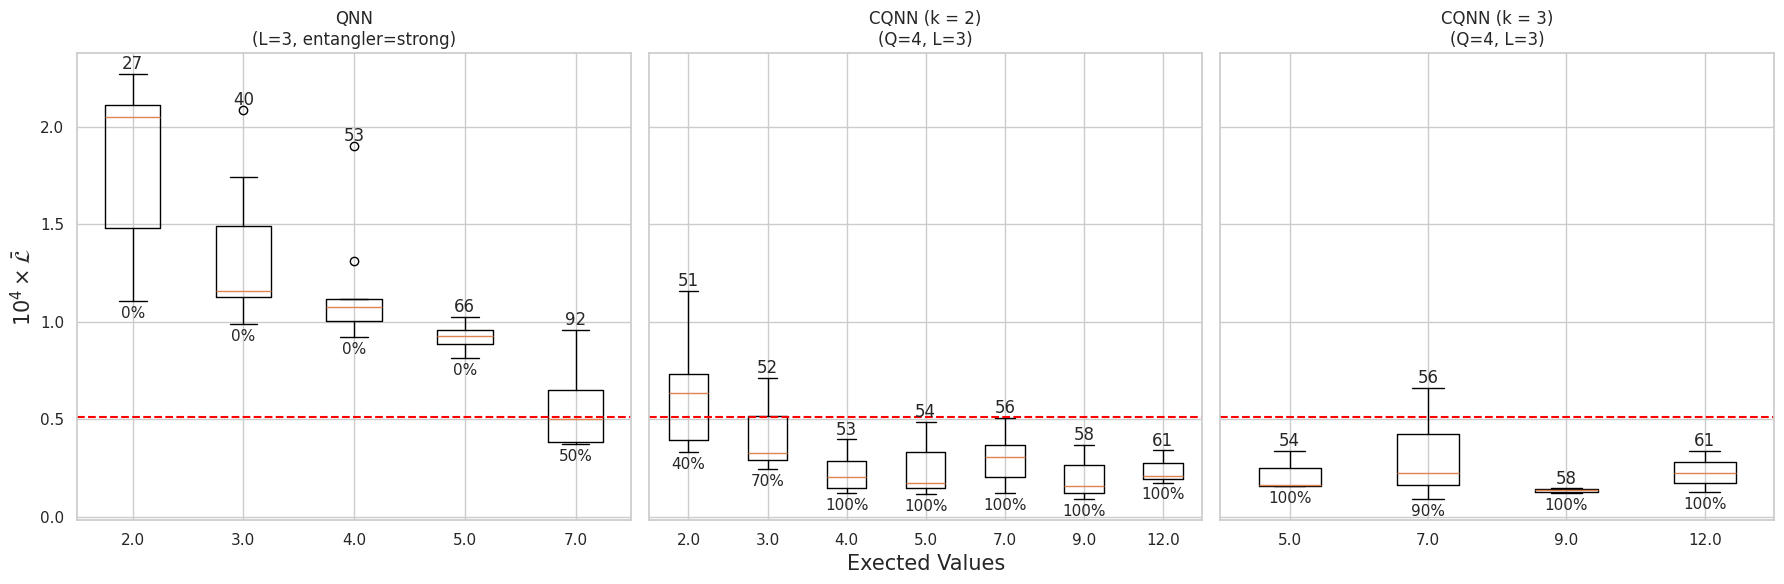

QNN: {2.0: 15, 3.0: 10, 4.0: 10, 5.0: 10, 7.0: 10}
CQNN k=2: {2.0: 10, 3.0: 10, 4.0: 8, 5.0: 3, 7.0: 10, 9.0: 3, 12.0: 3}
CQNN k=3: {5.0: 3, 7.0: 10, 9.0: 3, 12.0: 3}


In [1454]:

# =========================================================
# 1. Filtragem dos dados
#    - fixa n_layers e entangler
#    - QNN: deixa n_qubits variar
#    - CQNN: fixa n_qubits (pra comparar) e deixa n_vertex variar
# =========================================================

# QNN: varia n_qubits, fixa layers
df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_layers"] == n_layers_fixed)
]


df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_layers"] == n_layers_fixed) &
    (df_all["n_qubits"] == n_qubits_cqnn_fixed)
]

# =========================================================
# 2. Função para taxa de convergência
# =========================================================
def compute_conv(groups, thr):
    conv = {}
    for key, vals in groups.items():
        arr = np.asarray(vals)
        conv[key] = 100 * np.mean(arr < thr)
    return conv

# =========================================================
# 3. Agrupamento — QNN (x = n_qubits)
# =========================================================
groups_qnn = df_qnn.groupby("n_qubits")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_qnn = groups_qnn.tolist()
labels_qnn = [f"{q}" for q in groups_qnn.index]  # só o número

params_qnn = df_qnn.groupby("n_qubits")["num_params"].first().to_dict()
conv_qnn = compute_conv(groups_qnn, threshold)

# =========================================================
# 4. Agrupamento — CQNN por k e n_vertex (x = n_vertex)
# =========================================================

# k = 2
df_k2 = df_cqnn[df_cqnn["k"] == 2]
groups_k2 = df_k2.groupby("n_vertex")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_k2 = groups_k2.tolist()
labels_k2 = [f"{v}" for v in groups_k2.index]
params_k2 = df_k2.groupby("n_vertex")["num_params"].first().to_dict()
conv_k2 = compute_conv(groups_k2, threshold)

# k = 3
df_k3 = df_cqnn[df_cqnn["k"] == 3]
groups_k3 = df_k3.groupby("n_vertex")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_k3 = groups_k3.tolist()
labels_k3 = [f"{v}" for v in groups_k3.index]
params_k3 = df_k3.groupby("n_vertex")["num_params"].first().to_dict()
conv_k3 = compute_conv(groups_k3, threshold)

# =========================================================
# 5. Plotagem lado a lado (3 colunas)
# =========================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
offset = 0.025  # deslocamento vertical pros textos

# ---- Painel 1: QNN (x = n_qubits) ----
ax = axes[0]
if len(data_qnn) > 0:
    ax.boxplot(data_qnn, labels=labels_qnn)
ax.set_title(f"QNN\n(L={n_layers_fixed}, entangler={entangler})")
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=15)
#ax.set_xlabel("n_qubits", fontsize=12)
ax.grid(True)

for i, q in enumerate(groups_qnn.index):
    x_pos = i + 1
    vals = data_qnn[i]
    y_top = np.nanmax(vals)
    y_bot = np.nanmin(vals)

    # num_params em cima
    ax.text(x_pos, y_top + offset, f"{params_qnn[q]}", ha="center", fontsize=12)
    # taxa de convergência embaixo
    ax.text(
        x_pos,
        y_bot - offset,
        f"{conv_qnn[q]:.0f}%",
        ha="center",
        va="top",
        fontsize=11,
    )

# ---- Painel 2: CQNN k = 2 (x = n_vertex) ----
ax = axes[1]
if len(data_k2) > 0:
    ax.boxplot(data_k2, labels=labels_k2)
ax.set_title(f"CQNN (k = 2)\n(Q={n_qubits_cqnn_fixed}, L={n_layers_fixed})")
ax.set_xlabel("Exected Values", fontsize=15)
ax.grid(True)

for i, v in enumerate(groups_k2.index):
    x_pos = i + 1
    vals = data_k2[i]
    y_top = np.nanmax(vals)
    y_bot = np.nanmin(vals)

    ax.text(x_pos, y_top + offset, f"{params_k2[v]}", ha="center", fontsize=12)
    ax.text(
        x_pos,
        y_bot - offset,
        f"{conv_k2[v]:.0f}%",
        ha="center",
        va="top",
        fontsize=11,
    )

# ---- Painel 3: CQNN k = 3 (x = n_vertex) ----
ax = axes[2]
if len(data_k3) > 0:
    ax.boxplot(data_k3, labels=labels_k3)
ax.set_title(f"CQNN (k = 3)\n(Q={n_qubits_cqnn_fixed}, L={n_layers_fixed})")
#ax.set_xlabel("n_vertex", fontsize=12)
ax.grid(True)

for i, v in enumerate(groups_k3.index):
    x_pos = i + 1
    vals = data_k3[i]
    y_top = np.nanmax(vals)
    y_bot = np.nanmin(vals)

    ax.text(x_pos, y_top + offset, f"{params_k3[v]}", ha="center", fontsize=12)
    ax.text(
        x_pos,
        y_bot - offset,
        f"{conv_k3[v]:.0f}%",
        ha="center",
        va="top",
        fontsize=11,
    )

# ---- Linha do threshold ----
for ax in axes:
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

counts_qnn = {q: len(vals) for q, vals in groups_qnn.items()}
counts_k2  = {v: len(vals) for v, vals in groups_k2.items()}
counts_k3  = {v: len(vals) for v, vals in groups_k3.items()}

print("QNN:", counts_qnn)        # q -> número de runs pra aquele n_qubits
print("CQNN k=2:", counts_k2)    # v -> número de runs pra aquele n_vertex
print("CQNN k=3:", counts_k3)



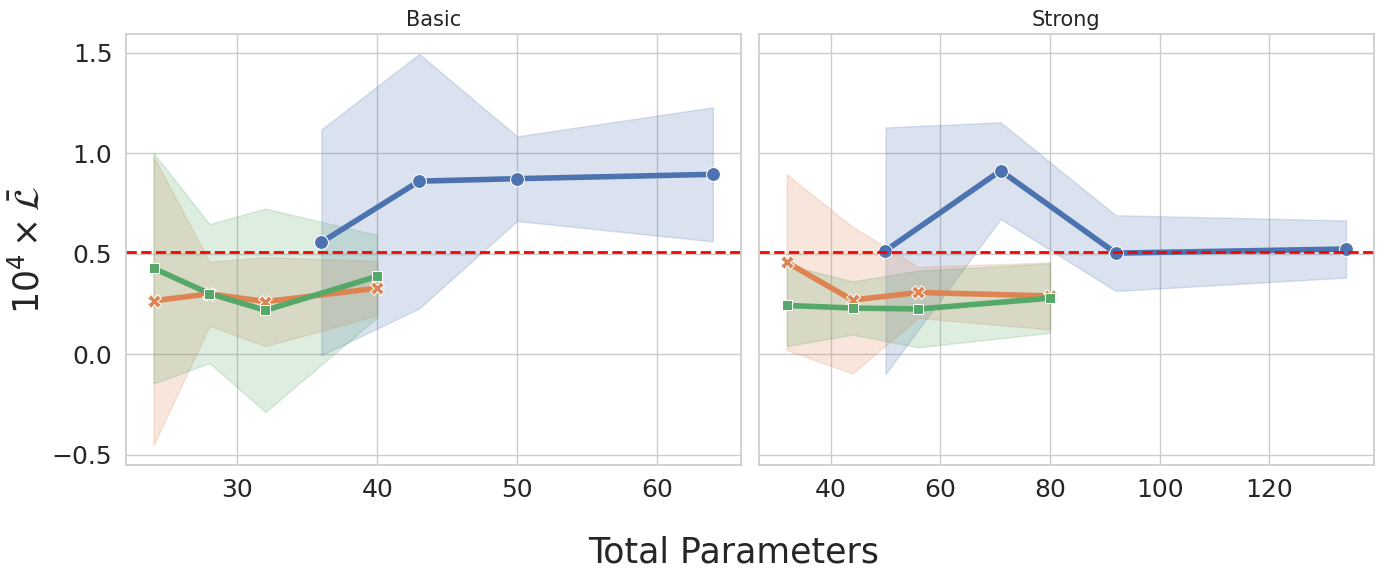

In [1455]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# CONFIG
# =========================================================

factor = 1e4
threshold = (1 / 140**2) * factor

valid_seeds = [1924, 1925, 1926, 1973, 2025, 2024, 2012, 1958, 1962, 1997]

df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["n_qubits"] == 7) &
    (df_all["seed"].isin(valid_seeds))
]

df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["n_vertex"] == 7) &
    (df_all["seed"].isin(valid_seeds))
]

df_basic_qnn = df_qnn[df_qnn["entangler"] == "basic"].copy()
df_basic_cqnn = df_cqnn[df_cqnn["entangler"] == "basic"].copy()

df_strong_qnn = df_qnn[df_qnn["entangler"] == "strong"].copy()
df_strong_cqnn = df_cqnn[df_cqnn["entangler"] == "strong"].copy()

df_basic_qnn["model"] = "QNN"
df_strong_qnn["model"] = "QNN"

df_basic_k2 = df_basic_cqnn[df_basic_cqnn["k"] == 2].copy()
df_basic_k2["model"] = "CQNN k=2"

df_basic_k3 = df_basic_cqnn[df_basic_cqnn["k"] == 3].copy()
df_basic_k3["model"] = "CQNN k=3"

df_strong_k2 = df_strong_cqnn[df_strong_cqnn["k"] == 2].copy()
df_strong_k2["model"] = "CQNN k=2"

df_strong_k3 = df_strong_cqnn[df_strong_cqnn["k"] == 3].copy()
df_strong_k3["model"] = "CQNN k=3"

for df_ in [
    df_basic_qnn, df_basic_k2, df_basic_k3,
    df_strong_qnn, df_strong_k2, df_strong_k3
]:
    df_["loss_scaled"] = df_["mean_last_100_loss"] * factor

df_basic = pd.concat([df_basic_qnn, df_basic_k2, df_basic_k3], ignore_index=True)
df_strong = pd.concat([df_strong_qnn, df_strong_k2, df_strong_k3], ignore_index=True)

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --------------------------------------------------------
# SUBPLOT 1 — BASIC
# --------------------------------------------------------
sns.lineplot(
    data=df_basic,
    x="num_params",
    y="loss_scaled",
    hue="model",
    style="model",
    markers=True,
    dashes=False,
    estimator="median",
    errorbar=("sd"),
    lw=4,
    markersize=10,      # <<< marcadores maiores
    ax=axes[0],
    legend=False
)

axes[0].axhline(y=threshold, color='red', linestyle='--', linewidth=2)
axes[0].set_title("Basic", fontsize=15)
axes[0].set_ylabel(r"$10^{4}\times\bar{\mathcal{L}}$", fontsize=25)

# --------------------------------------------------------
# SUBPLOT 2 — STRONG
# --------------------------------------------------------
sns.lineplot(
    data=df_strong,
    x="num_params",
    y="loss_scaled",
    hue="model",
    style="model",
    markers=True,
    dashes=False,
    estimator="median",
    errorbar=("sd"),
    lw=4,
    markersize=10,      # <<< marcadores maiores
    ax=axes[1],
    legend=False
)

axes[1].axhline(y=threshold, color='red', linestyle='--', linewidth=2)
axes[1].set_title("Strong", fontsize=15)
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# =========================================================
# AJUSTES — eixos
# =========================================================

# Y ticks fixos
yticks = np.arange(-0.5, 1.51, 0.5)
axes[0].set_yticks(yticks)

# (você ainda pode ajustar os xticks aqui se quiser)

# fonte dos ticks
for ax in axes:
    ax.tick_params(axis="both", labelsize=18)

# --------------------------------------------------------
# Layout final
# --------------------------------------------------------
fig.text(0.53, -0.02, "Total Parameters", ha="center", fontsize=25)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # um pouquinho mais de espaço embaixo
plt.savefig(
    "./experimentos_pinn/figures/lineplot_qnn_cqnn_basic_strong.png",
    dpi=300,
    #bbox_inches="tight"   # <<< evita cortar bordas
)
plt.show()


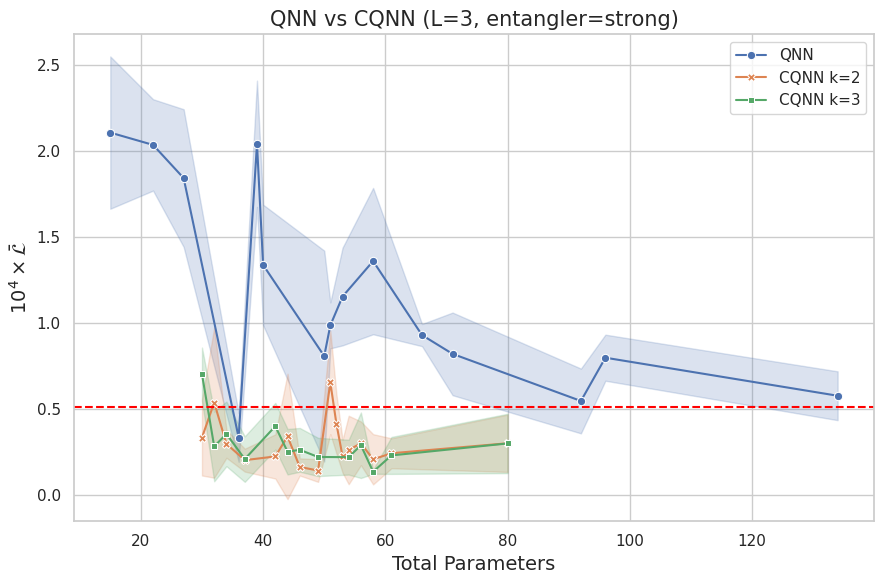

In [1456]:
df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == entangler)
]


df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_qubits"] == n_qubits_cqnn_fixed)
]


# =========================================================
# 1. Preparar dataframes para plot
# =========================================================

# QNN → variando n_qubits
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

# CQNN k=2 → variando n_vertex
df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

# CQNN k=3 → variando n_vertex
df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_["mean_last_100_loss"] * factor

# dataframe unificado
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# =========================================================
# 2. Lineplot
# =========================================================
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",         # <--- AGORA O EIXO X É NÚMERO DE PARÂMETROS
    y="loss_scaled",
    hue="model",
    style="model",
    markers=True,
    dashes=False,
    errorbar="sd",          # média ± desvio padrão
    ax=ax
)

threshold = (1 / 140**2) * factor
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Total Parameters", fontsize=14)
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=14)
ax.set_title(f"QNN vs CQNN (L={n_layers_fixed}, entangler={entangler})", fontsize=15)

ax.legend(title=None)
plt.tight_layout()
plt.show()


In [1457]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # importa o 3D
from matplotlib import cm

# ===============================
# 1) Filtra os três modelos
# ===============================

df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == "strong")
]

df_cqnn_k1 = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == "strong") &
    (df_all["k"] == 1)
]

df_cqnn_k2 = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == "strong") &
    (df_all["k"] == 2)
]

# ===============================
# 2) Função auxiliar:
#    monta uma matriz [layers x qubits]
#    com a *melhor* (mínima) loss
# ===============================

def best_loss_matrix(df, qubit_col="n_qubits", layer_col="n_layers",
                     loss_col="mean_last_100_loss"):
    qubits = sorted(df[qubit_col].unique())
    layers = sorted(df[layer_col].unique())

    M = np.full((len(layers), len(qubits)), np.nan)

    for i, L in enumerate(layers):
        for j, Q in enumerate(qubits):
            sub = df[(df[layer_col] == L) & (df[qubit_col] == Q)]
            if len(sub) > 0:
                M[i, j] = sub[loss_col].min()   # melhor loss (mínima)

    return M, qubits, layers

M_qnn, qubits_qnn, layers_qnn = best_loss_matrix(df_qnn)
M_k1,  qubits_k1,  layers_k1  = best_loss_matrix(df_cqnn_k1, qubit_col="n_vertex")
M_k2,  qubits_k2,  layers_k2  = best_loss_matrix(df_cqnn_k2, qubit_col="n_vertex")


In [1458]:
# =============================================================================
# 4. THRESHOLD de convergência
# =============================================================================
# Defina o limiar de loss que caracteriza "convergiu"
THRESH_LOSS = 1/ (V_max**2)   # ex.: mesmo que você já usa nos plots (~1/140^2)
# THRESH_LOSS = 1e-3            # (opção manual)
print("Threshold de loss:", THRESH_LOSS)


Threshold de loss: 5.102040816326531e-05
